# Эксперименты
### Модели:
* feed forward nn
* lstm
* fuzzy Cognitive Maps


### Данные

* y = x
* y = sin(x)
* y = x^2 + 2x + 1
* y = (x^2 + 2x + 1)/5 + sin(x)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils.data as Data

from copy import deepcopy

random_seed = 1

# FCM

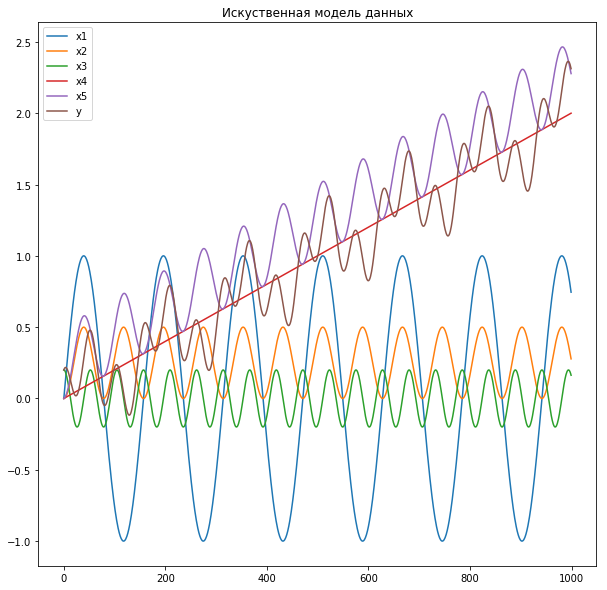

In [2]:
def example_data(need_plot=False, length=100, start=.0, end=4.):
    """
    Пример хоть и без циклов, но все равно более могущественная штука,
    ее будет непросто предсказать нейронке без дополнительных фич.
    todo можно поисследовать или даже можно математически вывести, какие
    именно фичи смогут восстановить равновесие по могуществу.
    Скорее всего, одну такую петлю можно разорвать с помощью просто
    квадратичной фичи. Но много фич -- это плохо, а тут они действуют
    локально, только на то, на что нужно, на что показал эксперт.
    Если такие петли оказываются вложенными, то они будут нужны уже
    не квадратичные фичи, а 4 степени (?) или большая глубина (!).
    Большн фич -- больше возможность переобучиться. Большая глубина --
    меньше возможность интерпретации
    
    Еще можно с помощью карты вычислять дискретные вещи, если накладывать на
    концепты времена жизни, например
    """
    
    lsp = np.linspace(start, end,length)
    
    x1 = np.sin(lsp*10)
    x2 = np.power(x1, 2) / 2
    x3 = np.cos(lsp*30)/5
    x4 = 0.5*lsp
    x5 = x2 + x4
    
    y = x1/5 + x3 +x4

    
    coef_del = 1
    x1, x2, x3, x4, x5, y = x1 / coef_del, x2 / coef_del, x3 / coef_del, x4 / coef_del, x5 / coef_del, y / coef_del

    if need_plot:
        plt.plot(x1, label='x1')
        plt.plot(x2, label="x2")
        plt.plot(x3, label="x3")
        plt.plot(x4, label="x4")
        plt.plot(x5, label="x5")
        plt.plot(y, label='y')
        plt.legend()
    
    return x1, x2, x3, x4, x5, y

plt.figure(1, figsize=(10,10))
plt.title("Искуственная модель данных")

    
example_data(need_plot=True, length=1000);

In [59]:
class FCM:
    class LSTMModel(nn.Module):
        def __init__(self, hidden, n_steps_in, n_steps_out, n_features):
            super(FCM.LSTMModel, self).__init__()
            self.hidden_dim = hidden
            self.n_steps_in = n_steps_in
    #         self.batch_size = batch_size
            self.linear_in = self.hidden_dim * self.n_steps_in

            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.lstm = nn.LSTM(n_features, self.hidden_dim, batch_first=True).double().cuda()

            # The linear layer that maps from hidden state space to tag space
            self.linear = nn.Linear(self.linear_in, n_steps_out).double().cuda()
            self.hidden = self.init_hidden(1)


        def init_hidden(self, batch_size):
            # Before we've done anything, we dont have any hidden state.
            # Refer to the Pytorch documentation to see exactly
            # why they have this dimensionality.
            # The axes semantics are (num_layers, minibatch_size, hidden_dim)
#             print("init hidden", batch_size)
            return (torch.zeros(1, batch_size, self.hidden_dim, dtype=torch.float64).cuda(),
                    torch.zeros(1, batch_size, self.hidden_dim, dtype=torch.float64).cuda())

        def forward(self, data, debug=False):
            lstm_out, self.hidden = self.lstm(data.cuda(), self.hidden)
            if debug:
                print("lstm_out.shape", lstm_out.shape)
                print("reshape", self.hidden_dim, self.n_steps_in)
            to_lin = lstm_out.contiguous().view(-1, self.linear_in)
            if debug:
                print("to_lin", to_lin.shape)
            res = self.linear(to_lin)
            if debug:
                print("res.shape", res.shape)
            return res
    
    
    def __init__(self, name="Fuzzy Cognitive Map", activation=None, neural=True,
                 learning_rate=1e-4, hidden_size=100,
                with_epoch_num=False, with_prev=False, train_shift=10,
                n_steps_in=10, n_steps_out=10):
        self.name = name

        def sigmoid(x):
            """Сигмоидальная функция"""
            return 1 / (1 + np.exp(-x))

        self.activation = activation if activation is not None else sigmoid
        self.graph = nx.DiGraph()
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.loss_function = torch.nn.L1Loss()
        
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        
        self.with_epoch_num = with_epoch_num
        self.with_prev = with_prev

        self.train_shift = train_shift

    @classmethod
    def init_from_concept_list(self, concepts):
        """
        Инициализирует полносвязную карту с рандомными весами
        из списка концептов concepts
        :param concepts -- список концептов
        """
        fcm = self()
        for c in concepts:
            fcm.add_new_concept(c, value=None)
        for c1 in concepts:
            for c2 in concepts:
                fcm.connect_concepts(c_from=c1, c_to=c2,
                                     weight=random.random())
                fcm.connect_concepts(c_from=c2, c_to=c1,
                                     weight=random.random())

        return fcm

    def freeze(self):
        '''
        Этот метод должен вызываться, если
        топология карты меняться не будет.
        Строим модельки для каждого концепта.
        '''
        for c in self.graph:
            len_precending = len(self.get_pred_concepts_names(c))
            
            features = len_precending + 1 # значение текущего концепта

            self.graph.nodes[c]['model'] = self.LSTMModel(
                self.hidden_size, self.n_steps_in, self.n_steps_out, features
            ).cuda().train()


    def add_new_concept(self, cname, value=None, history=None):
        """
        Добавить новый концепт в карту.
        """
        if history is None:
            history = []

        self.graph.add_node(cname, concept_value=value, history=history)
        return

    def connect_concepts(self, c_from=None, c_to=None, weight=0):
        """
        Метод позволяет связать концепты между собой и указать вес связи.
        """
        if c_from is None or c_to is None:
            raise Exception("c_from and c_to is required for link_concepts")
        self.graph.add_weighted_edges_from([(c_from, c_to, weight)])
        return

    def get_pred_concepts_names(self, concept_name):
        """
        Получить предшествующие концепты
        """
        return sorted(self.graph.predecessors(concept_name))
    
    
    def split_sequences(self, sequences, n_steps_in, n_steps_out, shift=1):
        X, y = list(), list()
        for i in range(0, len(sequences), shift):
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x = sequences[i:end_ix, :]
            seq_y = sequences[end_ix:out_end_ix, -1]
            X.append(seq_x)
            y.append(seq_y)
            
#         y = np.expand_dims(np.array(y), 2)
        return np.array(X), np.array(y)

    def fit_on_history(self, epochs=10, debug=False, optim='adam', split_sequenses_shift=1):
        """
        Обучает веса концептов или модели, связанные с концептами на основе сохраненной истории
        о том, как менялось состояние карты.
        """
        loss_history = []
        for concept_name in self.graph:
            # todo можно параллелить вычисление обучение
            if 'model' not in self.graph.nodes[concept_name]:
                continue

            model = self.graph.nodes[concept_name]['model']
            model = model.train()
            loss_fn = torch.nn.MSELoss(reduction='sum')
            
            if optim == 'adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
            elif optim == 'sgd':
                optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)
            else:
                raise ValueError("unknown optimizer", optim)
            
            pred_concepts_names = self.get_pred_concepts_names(concept_name)
            pred_concepts_names.append(concept_name)
            
            histories = []
            for c in pred_concepts_names:
                expanded = np.expand_dims(np.array(self.graph.nodes[c]['history']), 1)
                histories.append(expanded)

            histories = np.hstack(histories)
            
            if debug:
                print("histories.shape", histories.shape)

            x, y = self.split_sequences(histories, self.n_steps_in, self.n_steps_out, shift=split_sequenses_shift)

#             y = y.reshape(-1, len(pred_concepts_names) * self.n_steps_out)
            
            if debug:
                print("xshape yshape:", x.shape, y.shape)

            criterion = nn.MSELoss()

            hist_seq = torch.from_numpy( x ).double().cuda()
            labels_seq = torch.from_numpy( y ).double().cuda()

            for epoch in range(epochs):
                if debug and epoch % 10 == 0:
                    print("hist_seq.shape", hist_seq.shape)
                    print(f"epoch {epoch}")

                optimizer.zero_grad()
                model.hidden = model.init_hidden(hist_seq.shape[0])

                output = model.forward(hist_seq, debug=debug)

                if debug:
                    print("output", output.shape, 'labels_seq', labels_seq.shape)

                loss = criterion(output, labels_seq)
                loss_history.append(loss.item())

                loss.backward()
                optimizer.step()

            self.graph.nodes[concept_name]['model'] = model

        return loss_history

    
    def fcm_evalute(self, debug=False, since=None, till=None, epochs=None, from_epoch=0):
        hist_copy = deepcopy(nx.get_node_attributes(self.graph, 'history'))
        res_hist = dict()
    
        hidden_inited = dict()
            
        
        if since is not None:
            
            if till is None:
                till = since + self.n_steps_in
                
            for concept in self.graph.nodes:
                res_hist[concept] = self.graph.nodes[concept]['history'][since:since+self.n_steps_in]
            
            for e in range(since, till, self.n_steps_in):
                e_since = e
                e_till = e + self.n_steps_in
                
                if debug:
                    print('borders:', e_since, e_till)
                
                for concept in self.graph.nodes:
                    pred_concepts_names = self.get_pred_concepts_names(concept)
                    pred_concepts_names.append(concept)

                    histories = []
                    
                    for c in pred_concepts_names:
                        expanded_hist = np.expand_dims(np.array(res_hist[c][e_since:e_till]), 1)
                        histories.append(expanded_hist)
                    
                    recent_history = np.hstack(histories)
    
                    if debug:
                        print("recent_history", recent_history.shape)

                    recent_history_tensor = torch.from_numpy( recent_history ).unsqueeze_(0).double().cuda()
                    
                    model = self.graph.nodes[concept]['model']
                    model = model.train()
                    
                    if concept not in hidden_inited:
                        hidden_inited[concept] = True
                        model.hidden = model.init_hidden(recent_history_tensor.shape[0])

                    output = model.forward(recent_history_tensor, debug=debug)
                    
                    res_hist[concept].extend(list(output[0, :].cpu().detach().numpy()))

        elif epochs is not None:
            
            if self.n_steps_in != self.n_steps_out:
                raise NotImplementedError("cant do prediction if self.n_steps_in != self.n_steps_out")
            
            # добавляем фиктивную историю
#             res_hist = dict()
            for concept in self.graph.nodes:
                res_hist[concept] = self.graph.nodes[concept]['history'][-self.n_steps_in:]
            
            for e in range(0, epochs, self.n_steps_in):
                if debug:
                    print("epoch: ", e)
                for concept in self.graph.nodes:
                                                    
                    pred_concepts_names = self.get_pred_concepts_names(concept)
                    pred_concepts_names.append(concept)

                    histories = []
                    
                    for c in pred_concepts_names:
                        expanded_hist = np.expand_dims(np.array(res_hist[c][-self.n_steps_in:]), 1)
                        histories.append(expanded_hist)
                    
                    recent_history = np.hstack(histories)
    
                    if debug:
                        print("recent_history", recent_history.shape)

                    recent_history_tensor = torch.from_numpy( recent_history ).unsqueeze_(0).double().cuda()
                    
                    model = self.graph.nodes[concept]['model']
                    model = model.train()
                    
                    if concept not in hidden_inited:
                        hidden_inited[concept] = True
                        model.hidden = model.init_hidden(recent_history_tensor.shape[0])

                    output = model.forward(recent_history_tensor, debug=debug)
                    
                    res_hist[concept].extend(list(output[0, :].cpu().detach().numpy()))

        else:
            raise ValueError("either since + till or epochs must be defined")
            
        for concept in self.graph.nodes:
            res_hist[concept] = res_hist[concept][self.n_steps_in:]

        return res_hist
    
    def concepts(self):
        """
        Получить список концептов карты
        """
        return self.graph.nodes

    def get_concept_values(self):
        """
        Получить значения всех концептов
        """
        return nx.get_node_attributes(self.graph, 'concept_value')

    def plot_map(self, plotsize=(5, 5), draw_edges=True):
        """
        Строит граф карты.
        """
        pos = nx.circular_layout(self.graph)

        plt.clf()
        cf = plt.gcf()
        cf.set_size_inches(*plotsize)
        ax = cf.gca()

        DGresult = self.graph

        labels = { x: x for x in list(self.graph.nodes)}
        nx.draw_networkx_nodes(self.graph, pos,
                               labels=labels,
                               node_color="blue",
                               node_size=1000,
                               alpha=0.3,
                               ax=ax)
        nx.draw_networkx_labels(DGresult, pos, labels, font_size=10)

        if draw_edges:
            for c, inners in DGresult.pred.items():
                for inner in inners:
                    edge_color = 'green'
                    nx.draw_networkx_edges(DGresult, pos,
                                           edgelist=[(inner, c)],
                                           width=3, alpha=0.3, edge_color=edge_color, ax=ax, arrowsize=30)


    def plot_concept_history(self, hstart=0, hend=None, colors=None):
        """
        Строит график изменения значений концептов карты
        """
        if colors is None:
            colors = dict()
        
        cf = plt.gcf()
        cf.set_size_inches(18, 10)

        history = nx.get_node_attributes(self.graph, 'history')
        for c in history:
            h = history[c]
            color = colors.get(c)
            if hend is not None:
                h = h[hstart:hend]
            plt.plot(range(len(history[c])), h, label=c, c=color)
            plt.xlabel('iteration')
            plt.ylabel('concept value')
            plt.grid()
            plt.legend()


In [60]:
%%time

colors = {
    "x1": 'green',
    "x2": 'brown',
    "x3": 'yellow',
    "x4": 'red',
    "x5": 'blue',
    "y":  'black',
}

def train_fcm(fbFCM, eval_epochs=10, epochs=100, plot_map=True,
              plot_loss=False, plot_concept_hostory=False, plot_predicted=False, plot_predicted_old_data=False):

    
    fbFCM.freeze()
    fignum = 0
    
    if plot_map:
        plt.figure(fignum)
        fignum += 1
        fbFCM.plot_map()

    loss = fbFCM.fit_on_history(epochs=epochs, debug=False, optim='adam')
    if plot_loss:
        plt.figure(fignum)
        fignum += 1
        plt.plot(loss)
        plt.title("loss")

    if plot_concept_hostory:
        plt.figure(fignum)
        fignum += 1
        # исторические данные
        fbFCM.plot_concept_history(colors=colors)
    
    res = fbFCM.fcm_evalute(debug=False, epochs=eval_epochs)

    if plot_predicted:
        plt.figure(fignum)
        fignum += 1

        plt.title("predicted")
        for k in res:
            plt.plot(res[k], label=f'{k}_predicted', c=colors.get(k))
        plt.legend()
        
    if plot_predicted_old_data:
        plt.figure(fignum)
        fignum += 1
        res = fbFCM.fcm_evalute(debug=False, since=0, till=200)
        plt.title("predicted old_data")
        for k in res:
            plt.plot(res[k], label=f'{k}_predicted', c=colors.get(k))
        plt.legend()
        
    return fbFCM

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.7 µs


In [61]:
length = 1000
start=0.
end=8.
x1, x2, x3, x4, x5, y = example_data(need_plot=False, length=length, start=start, end=end);

In [62]:
def preduct_long(_model):
    
    _prediction100 = _model.fcm_evalute(debug=False, epochs=1000)
    varname2data = {
        "x1": list(x1),
        "x2": list(x2),
        "x3": list(x3),
        "x4": list(x4),
        "x5": list(x5),
        "y":  list(y),
    }
    
    plt.gcf().set_size_inches(18, 10)
    for c in colors:
        prev_data = varname2data.get(c)        
        
        data = _prediction100.get(c)
        if data is None:
            continue
        
        prev_data.extend(data)
        
        color = colors.get(c)
        plt.plot(prev_data, label=c, c=color)
    
    plt.axvline(x=length, ymin=-1, ymax=1)
    plt.legend()


# Осмысленные связи

predict
CPU times: user 1min 4s, sys: 36.4 s, total: 1min 40s
Wall time: 1min 40s


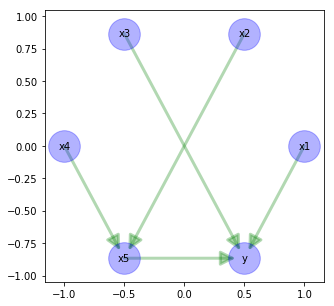

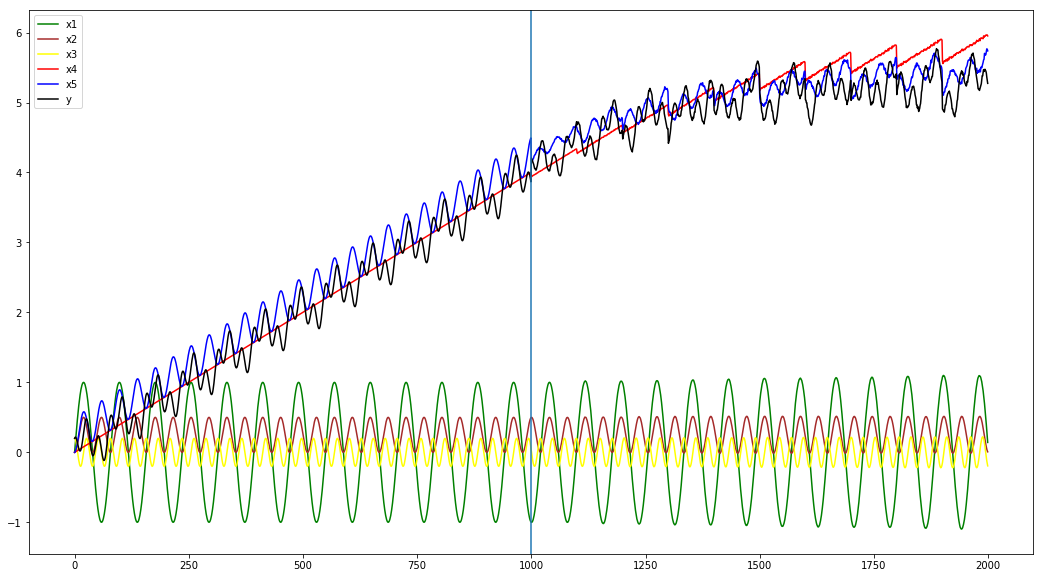

In [63]:
%%time

# x1 = np.sin(lsp*10)
# x2 = np.power(x1, 2) / 2
# x3 = np.cos(lsp*30)/5
# x4 = x2 + 0.5*lsp
# y = x1/5 + x3 +x4

_model = FCM(n_steps_in=100, n_steps_out=100, learning_rate=1e-3, hidden_size=100)

_model.add_new_concept("x1", history=list(x1))
_model.add_new_concept("x2", history=list(x2))
_model.add_new_concept("x3", history=list(x3))
_model.add_new_concept("x4", history=list(x4))
_model.add_new_concept("x5", history=list(x5))
_model.add_new_concept("y",  history=list(y))

# _model.connect_concepts(c_from="x1", c_to="x2")
_model.connect_concepts(c_from="x2", c_to="x5")
_model.connect_concepts(c_from="x4", c_to="x5")

_model.connect_concepts(c_from="x1", c_to="y")
_model.connect_concepts(c_from="x3", c_to="y")
_model.connect_concepts(c_from="x5", c_to="y")

# _model = train_fcm(_model, epochs=10, eval_epochs=100);
_model = train_fcm(_model, epochs=100, eval_epochs=100);

print("predict")
plt.figure(5)
preduct_long(_model)

# Без связей

Есть проблемы с предсказанием данных, на которых сеть не обучалась. Получается отстой

CPU times: user 1min 1s, sys: 37.3 s, total: 1min 38s
Wall time: 1min 38s


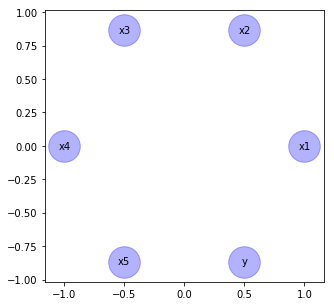

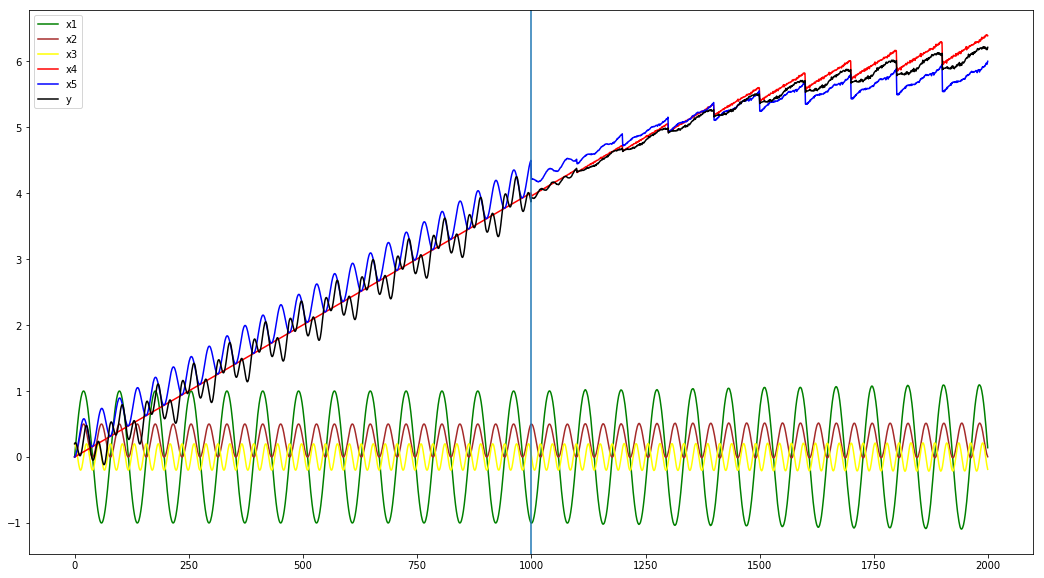

In [36]:
%%time

_model = FCM(n_steps_in=100, n_steps_out=100, learning_rate=1e-3, hidden_size=100)

_model.add_new_concept("x1", history=list(x1))
_model.add_new_concept("x2", history=list(x2))
_model.add_new_concept("x3", history=list(x3))
_model.add_new_concept("x4", history=list(x4))
_model.add_new_concept("x5", history=list(x5))
_model.add_new_concept("y",  history=list(y))

_model = train_fcm(_model, epochs=100, eval_epochs=100);
plt.figure(5)
preduct_long(_model)

# Полносвязный граф

CPU times: user 1min 5s, sys: 37 s, total: 1min 42s
Wall time: 1min 42s


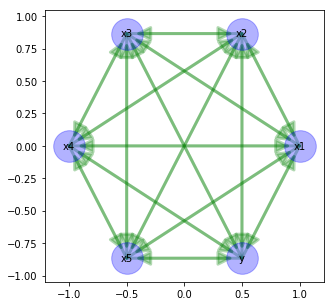

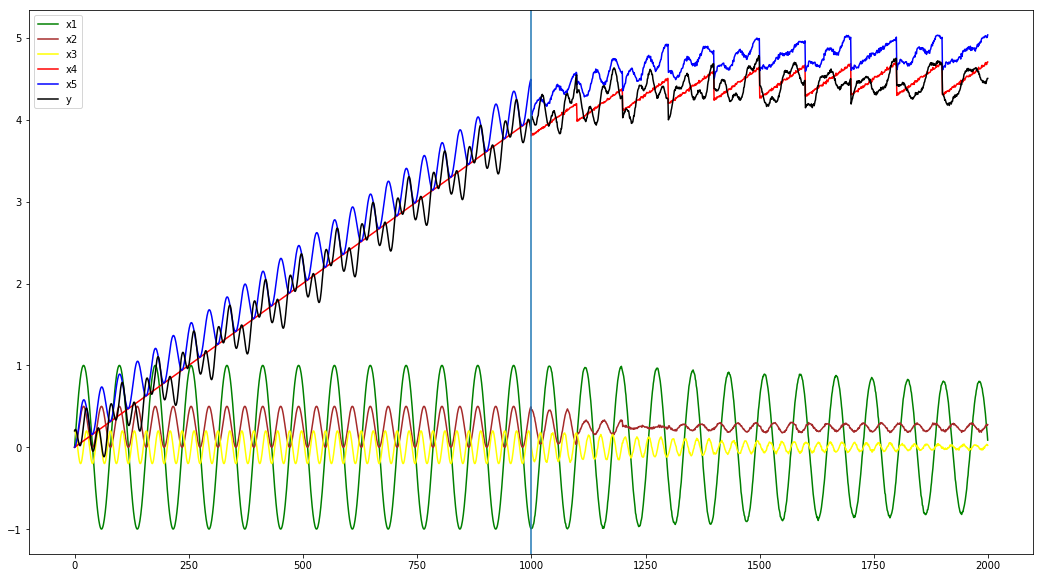

In [106]:
%%time

_model = FCM(n_steps_in=100, n_steps_out=100, learning_rate=1e-3, hidden_size=100)

_model.add_new_concept("x1", history=list(x1))
_model.add_new_concept("x2", history=list(x2))
_model.add_new_concept("x3", history=list(x3))
_model.add_new_concept("x4", history=list(x4))
_model.add_new_concept("x5", history=list(x5))
_model.add_new_concept("y",  history=list(y))

for c1 in _model.graph.nodes:
    for c2 in _model.graph.nodes:
        if c1 == c2:
            continue
        _model.connect_concepts(c_from=c1,  c_to=c2)
        _model.connect_concepts(c_from=c2,  c_to=c1)

_model = train_fcm(_model, epochs=100, eval_epochs=100);
plt.figure(5)
preduct_long(_model)

Короче, просто предсказывать последовательности не очень хорошо. Вычислять значения какого-то одного концепта по известным другум, в принципе, нормально. Но смысла в этом не очень много. Параметров у модели, может быть, будет и меньше, меньше возможность переобучения. Но большого профита это не даст и, возможно, будет только больше тупить, потому что распараллеливание умножений матриц на видююхах сейчас нормально работают. 

Получается, на самом деле, в картах нет ничего инновационного. Сами их вычилсения получаются отстойными, 

# Попробуем с помощью одной модели предсказать что-то

(1000, 1) (1000, 1)
xy.shape (1000, 6)
x.shape, y.shape (801, 100, 6) (801, 600)
test_from 666
x_train (666, 100, 6)


No handles with labels found to put in legend.


predictions (1, 100, 6)
predictions torch.Size([1, 600])
x1.shape (1000, 1)
CPU times: user 2min 23s, sys: 29.4 s, total: 2min 52s
Wall time: 1min


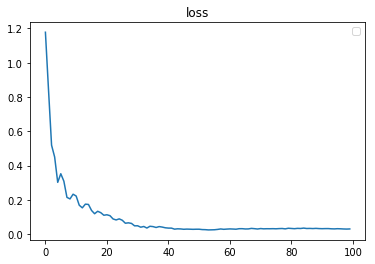

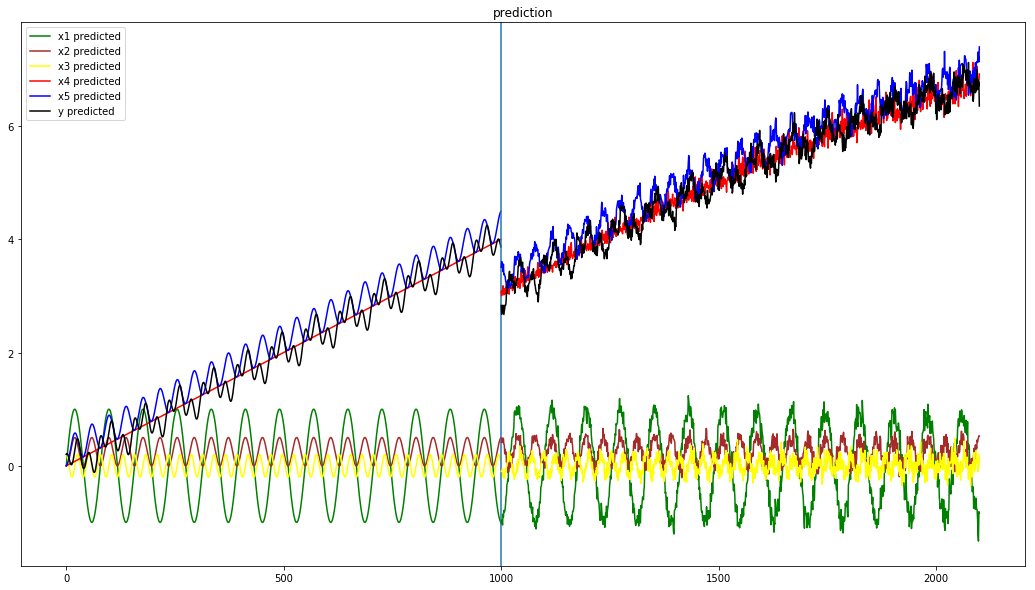

In [68]:
%%time

class ModelLSTM(nn.Module):
    def __init__(self, hidden, n_steps_in, n_steps_out, n_features):
        super(ModelLSTM, self).__init__()
        self.hidden_dim = hidden
        self.n_steps_in = n_steps_in
#         self.batch_size = batch_size
        self.linear_in = self.hidden_dim * self.n_steps_in

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(n_features, self.hidden_dim, batch_first=True).double().cuda()

        # The linear layer that maps from hidden state space to tag space
        self.linear = nn.Linear(self.linear_in, n_steps_out * n_features).double().cuda()
        self.hidden = self.init_hidden(1)

    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, batch_size, self.hidden_dim, dtype=torch.float64).cuda(),
                torch.zeros(1, batch_size, self.hidden_dim, dtype=torch.float64).cuda())

    def forward(self, data, debug=False):
        lstm_out, self.hidden = self.lstm(data.cuda(), self.hidden)
        if debug:
            print("lstm_out.shape", lstm_out.shape)
            print("reshape", self.hidden_dim, self.n_steps_in)
        to_lin = lstm_out.contiguous().view(-1, self.linear_in)
        if debug:
            print("to_lin", to_lin.shape)
        res = self.linear(to_lin)
        if debug:
            print("res.shape", res.shape)
        return res


def train_lstm(_lstm_model, epochs=100, learning_rate=1e-3, debug=False, n_steps_out=50, n_steps_in=50, ):
    model = _lstm_model

    length = 1000
    start=0.
    end=8.

    x1, x2, x3, x4, x5, y_original = example_data(need_plot=False, length=length, start=start, end=end)
    
    x1 = np.expand_dims(x1, 1)
    x2 = np.expand_dims(x2, 1)
    x3 = np.expand_dims(x3, 1)
    x4 = np.expand_dims(x4, 1)
    x5 = np.expand_dims(x5, 1)
    y = np.expand_dims(y_original, 1)
    print(x1.shape, y.shape)

    xy = np.hstack((x1, x2, x3, x4, x5, y))
    print("xy.shape", xy.shape)
        
    def split_sequences(sequences, n_steps_in, n_steps_out):
        X, y = list(), list()
        for i in range(len(sequences)):
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the dataset
            if out_end_ix > len(sequences):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    
    x, y_orig = split_sequences(xy, n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    
    y = y_orig.reshape(-1, n_features * n_steps_out)
    
    print("x.shape, y.shape", x.shape, y.shape)

    test_from = length//3*2
    print("test_from", test_from)
    x_train = x[:test_from]
    labels_train = y[:test_from]
    
    x_test = x[test_from:]
    labels_test = y[test_from:]
    
    print("x_train", x_train.shape)
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_history = []
    
    hist_seq = torch.from_numpy( x_train ).double().cuda()
    labels_seq = torch.from_numpy( labels_train ).double().cuda()

    model = model.train()
    for epoch in range(epochs):
        if debug and epoch % 1 == 0:
            print("hist_seq.shape", hist_seq.shape)
            print(f"epoch {epoch}")

        optimizer.zero_grad()
        model.hidden = model.init_hidden(hist_seq.shape[0])

        output = model.forward(hist_seq, debug=debug)

        if debug:
            print("output", output, 'labels_seq', labels_seq)

        loss = criterion(output, labels_seq)
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()
        
    figurenum = 0
    
    plt.figure(figurenum)
    figurenum += 1
    plt.title("loss")
    plt.legend()
    plt.plot(loss_history)

    plt.figure(figurenum, figsize=(18,10))
    figurenum += 1
    plt.title("prediction")
    model = model.eval()
    
    model.hidden = model.init_hidden(1)
    
    all_predictions = []
    predictions = np.array([x_test[0, :, :]])
    print('predictions', predictions.shape)
    predictions = torch.from_numpy(predictions).double().cuda()
    predictions = model(predictions)
    print('predictions', predictions.shape)
    predictions = predictions.cpu().detach().numpy()
    predictions = predictions.reshape(-1, n_steps_out, n_features)
    predictions = torch.from_numpy(predictions)
    
    init_pred_len = len(predictions)
    all_predictions.extend(predictions)
        
    print("x1.shape",x1.shape)
    varname2data = {
        "x1": list(x1[:, 0]),
        "x2": list(x2[:, 0]),
        "x3": list(x3[:, 0]),
        "x4": list(x4[:, 0]),
        "x5": list(x5[:, 0]),
        "y":  list(y_original),
    }

    for c in varname2data.keys():
        plt.plot(varname2data[c], c=colors.get(c))
    
    plt.axvline(x=length, ymin=-1, ymax=1)
    
    start = n_steps_out
    for i in range(length // n_steps_out):
        start += n_steps_out
#         print(predictions[0,0,0])
        predictions = model(predictions)
        
        predictions = predictions.cpu().detach().numpy()
        predictions = predictions.reshape(-1, n_steps_out, n_features)
        predictions = torch.from_numpy(predictions)
    
        all_predictions.extend(predictions)

#     all_predictions = all_predictions[init_pred_len:]

    return (model, x_test, all_predictions)



n_steps_in=100
n_steps_out=100
n_features=6
hidden=200
_lstm_model = ModelLSTM(hidden, n_steps_in, n_steps_out, n_features)
_lstm_model, _, all_pred = train_lstm(_lstm_model, epochs=100, n_steps_out=n_steps_out, n_steps_in=n_steps_in)
# _lstm_model, _, all_pred = train_lstm(_lstm_model, epochs=1, n_steps_out=n_steps_out, n_steps_in=n_steps_in)

for i in range(len(all_pred)):
    all_pred[i] = all_pred[i].numpy()
all_pred = np.array(all_pred)    
all_pred = all_pred.reshape(-1, n_features)
plt.figure(1, figsize=(10,10))
for j, conc in enumerate(['x1', 'x2', 'x3', 'x4', 'x5', 'y']):
        plt.plot(range(1000, 1000+len(all_pred[:, j])), all_pred[:, j], label=f'{conc} predicted', c=colors.get(conc))
plt.legend()
